In [2]:
pip install torch numpy pandas scikit-learn tensorflow shap scikit-optimize openpyxl numpy matplotlib scikit-learn scipy tensorflow boruta


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 7.4 MB/s eta 0:00:00


The code below does the following steps for data preparation:

1. **Loading Data**: It first loads data from each exchange (Binance, Coinbase, Kraken) into separate dataframes. The data is indexed by 'Coin' and 'Date'.

2. **Resetting Indices**: It then resets the indices of these dataframes so that 'Coin' and 'Date' become normal columns.

3. **Concatenating Dataframes**: It combines all three dataframes into one, storing the data from all exchanges in a single dataframe.

4. **Calculating Average Prices**: It calculates the average 'close' price for each 'Coin'-'Date' pair across all exchanges.

5.** Calculating Price Inconsistencies**: Using the calculate_price_inconsistency() function, it calculates the price inconsistency for each row in each exchange's data.

6. **One-Hot Encoding**: It performs one-hot encoding on the 'Coin' column, creating separate columns for each coin.

7. **Handling Missing Data**: Finally, it uses the handle_missing_data() function to handle missing data in each exchange's dataframe. This function fills in missing values using both backward and

In [3]:
from BTC_helper import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap

In [ ]:
#upload dependency files from E:\objective 3_code
binance_file_merged="/content/Binance_data_combined_v2_merged.xlsx"
coinbase_file_merged="/content/Coinbase_data_combined_v2_merged.xlsx"
kraken_file_merged="/content/Kraken_data_combined_v2_merged.xlsx"

# Load merged data from excel files into DataFrames
kraken_data = pd.read_excel(kraken_file_merged, index_col=[0, 1])
coinbase_data = pd.read_excel(coinbase_file_merged, index_col=[0, 1])
binance_data = pd.read_excel(binance_file_merged, index_col=[0, 1])
print("Binance Data\n",binance_data.tail(3))
#print("Kraken Data\n",kraken_data.tail(3))
#print("Coinbase Data\n",coinbase_data.tail(3))



Binance Data
                      open      high       low     close        volume  \
Coin Date                                                               
XRP  2023-04-18  0.514158  0.516034  0.501757  0.499401  9.488975e+08   
     2023-04-19  0.504747  0.508703  0.487858  0.488230  1.174681e+09   
     2023-04-20  0.491520  0.498827  0.468671  0.474858  1.484252e+09   

                 github_commits  google_trends  tweets      VWAP  \
Coin Date                                                          
XRP  2023-04-18             1.0             64   10932  0.682851   
     2023-04-19             1.0             74   10980  0.682807   
     2023-04-20             1.0             58   10971  0.682747   

                          OBV  ...        ADX      MACD  MACD_signal  \
Coin Date                      ...                                     
XRP  2023-04-18  3.996385e+11  ...  46.576025  0.016458     0.022590   
     2023-04-19  3.984638e+11  ...  43.825070  0.013340     0.0

In [ ]:
# Reset the indices of the dataframes
kraken_data_reset = kraken_data.reset_index()
coinbase_data_reset = coinbase_data.reset_index()
binance_data_reset = binance_data.reset_index()

# Concatenate the reset dataframes
combined_data = pd.concat([kraken_data_reset, coinbase_data_reset, binance_data_reset])

# Calculate the average 'close' price for each coin at each timestamp across all exchanges
average_prices = combined_data.groupby(['Date', 'Coin'])['close'].mean()

# Function to calculate price inconsistency
def calculate_price_inconsistency(data):
    # Reset the index of the data
    data_reset = data.reset_index()
    # Map the average prices to the data
    data_reset['average_price'] = data_reset.set_index(['Date', 'Coin']).index.map(average_prices)
    # Calculate the price inconsistency for each row as the absolute difference between the 'close' price and the average 'close' price
    data_reset['price_inconsistency'] = np.abs(data_reset['close'] - data_reset['average_price'])
    # Set the index back to ['Date', 'Coin']
    data_final = data_reset.set_index(['Date', 'Coin'])
    return data_final

# Apply the function to each dataframe
kraken_data_full = calculate_price_inconsistency(kraken_data)
coinbase_data_full = calculate_price_inconsistency(coinbase_data)
binance_data_full = calculate_price_inconsistency(binance_data)



# One-hot encode the Coin column to create separate columns for each coin
kraken_data_encoded = pd.get_dummies(kraken_data_full.reset_index(level='Coin'), columns=['Coin']).sort_index()
coinbase_data_encoded= pd.get_dummies(coinbase_data_full.reset_index(level='Coin'), columns=['Coin']).sort_index()
binance_data_encoded= pd.get_dummies(binance_data_full.reset_index(level='Coin'), columns=['Coin']).sort_index()
print(binance_data_encoded)
#binance_data_encoded.to_csv("binance_data_full.csv")
binance_data_encoded

                   open         high          low        close        volume  \
Date                                                                           
2017-01-01   961.974294   964.792136   942.240444   965.202234  1.164446e+08   
2017-01-01     4.617368     4.674184     4.470000     4.583671  1.246421e+07   
2017-01-01     0.006239     0.006392     0.006263     0.006374  1.084780e+06   
2017-01-01     8.566456     8.964149     8.317667     8.796849  1.797008e+07   
2017-01-01    11.589936    12.810720    11.426954    12.656489  4.085362e+06   
...                 ...          ...          ...          ...           ...   
2023-04-20  2058.651219  2028.816640  1955.785571  1940.088415  9.466329e+09   
2023-04-20    90.435072    91.883534    87.580449    90.239658  7.477496e+08   
2023-04-20    53.092521    53.497630    51.117428    51.672520  9.171417e+07   
2023-04-20     0.491520     0.498827     0.468671     0.474858  1.484252e+09   
2023-04-21  1943.409924  1955.649121  18

,open,high,low,close,volume,github_commits,google_trends,tweets,VWAP,OBV,...,Transaction Fee,AML_KYC_required,bid_ask_spread,average_price,price_inconsistency,Coin_BTC,Coin_DASH,Coin_ETH,Coin_LTC,Coin_XRP
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,961.974294,964.792136,942.240444,965.202234,1.164446e+08,1.3,0,21071,509.758590,6.770451e+09,...,0.001,1.0,0.023651,979.076117,13.873883,1,0,0,0,0
2017-01-01,4.617368,4.674184,4.470000,4.583671,1.246421e+07,1.0,0,296,9.281211,-5.056361e+08,...,0.001,1.0,0.044659,4.506835,0.076835,0,0,0,1,0
2017-01-01,0.006239,0.006392,0.006263,0.006374,1.084780e+06,1.0,0,5364,0.009341,-1.020175e+08,...,0.001,1.0,0.020277,0.006374,0.000000,0,0,0,0,1
2017-01-01,8.566456,8.964149,8.317667,8.796849,1.797008e+07,1.0,0,1791,11.470200,-4.066507e+08,...,0.001,1.0,0.074816,8.488424,0.308424,0,0,1,0,0
2017-01-01,11.589936,12.810720,11.426954,12.656489,4.085362e+06,8.0,0,2,8.333886,4.248272e+07,...,0.001,1.0,0.114183,12.656489,0.000000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-20,2058.651219,2028.816640,1955.785571,1940.088415,9.466329e+09,5.0,74,24423,1662.408598,2.024278e+12,...,0.001,1.0,0.036657,1941.624208,1.535792,0,0,1,0,0
2023-04-20,90.435072,91.883534,87.580449,90.239658,7.477496e+08,1.0,58,889,120.772130,5.257955e+11,...,0.001,1.0,0.047955,90.249829,0.010171,0,0,0,1,0
2023-04-20,53.092521,53.497630,51.117428,51.672520,9.171417e+07,2.0,58,249,163.957796,6.776757e+10,...,0.001,1.0,0.045504,51.661260,0.011260,0,1,0,0,0


In [ ]:
# Function to handle missing data and print missing values
def handle_missing_data(df, exchange_name):
    num_missing = df.isnull().sum()
    missing_values = num_missing[num_missing > 0]
    print(f'Initial missing values in {exchange_name} data:')
    print(missing_values)
    
    total_nans = num_missing.sum()
    print(f'Total number of NaN values in the DataFrame: {total_nans}')
    
    df = df.fillna(method='bfill')
    df = df.fillna(method='ffill')
    
    num_missing = df.isnull().sum()
    missing_values = num_missing[num_missing > 0]
    print(f'Missing values in {exchange_name} data after handling missing data:')
    print(missing_values)
    
    total_nans = num_missing.sum()
    print(f'Total number of NaN values in the DataFrame after handling missing data: {total_nans}')
    
    return df

# Apply the function to each dataframe
kraken_data_encoded = handle_missing_data(kraken_data_encoded, 'Kraken')
coinbase_data_encoded = handle_missing_data(coinbase_data_encoded, 'Coinbase')
binance_data_encoded = handle_missing_data(binance_data_encoded, 'Binance')
binance_data_encoded.to_csv("binance_data_encoded.csv")

Initial missing values in Kraken data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame: 0
Missing values in Kraken data after handling missing data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame after handling missing data: 0
Initial missing values in Coinbase data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame: 0
Missing values in Coinbase data after handling missing data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame after handling missing data: 0
Initial missing values in Binance data:
Maker Fee           1
Transaction Fee     1
AML_KYC_required    1
dtype: int64
Total number of NaN values in the DataFrame: 3
Missing values in Binance data after handling missing data:
Series([], dtype: int64)
Total number of NaN values in the DataFrame after handling missing data: 0


In [ ]:
coinbase_data

open       high        low      close        volume  \
Coin Date                                                                   
BTC  2017-01-01   973.3700  1000.0000   964.3700   992.9500  4.421503e+03   
     2017-01-02   992.9600  1034.3900   990.5200  1011.4500  7.723636e+03   
     2017-01-03  1011.5200  1036.9900  1006.7100  1020.6700  8.615260e+03   
     2017-01-04  1020.6900  1147.0000  1018.0000  1130.3000  1.622223e+04   
     2017-01-05  1131.1000  1175.0000   880.0000  1007.0000  2.044641e+04   
...                    ...        ...        ...        ...           ...   
XRP  2021-01-15     0.2962     0.3028     0.2614     0.2800  1.648915e+08   
     2021-01-16     0.2800     0.2968     0.2754     0.2792  1.267654e+08   
     2021-01-17     0.2790     0.2856     0.2684     0.2773  1.040702e+08   
     2021-01-18     0.2772     0.2890     0.2714     0.2856  1.395150e+08   
     2021-01-19     0.2856     0.3298     0.2841     0.3023  2.137782e+08   

                 github_commits  google_trends  tweets         VWAP  \
Coin Date                                                             
BTC  2017-01-01        1.000000              1   21071   985.773333   
     2017-01-02        3.000000              2   26461  1002.528355   
     2017-01-03       16.000000              2   27269  1010.383326   
     2017-01-04       48.000000              3   31611  1049.005986   
     2017-01-05       36.000000              3   33407  1038.916364   
...                         ...            ...     ...          ...   
XRP  2021-01-15       10.671888             10    8529     0.335523   
     2021-01-16       12.146553             11    6933     0.335399   
     2021-01-17       12.846191              8    5516     0.335285   
     2021-01-18       12.441307              8    6275     0.335145   
     2021-01-19       10.602408             11   12136     0.335026   

                          OBV  ...        ADX       MACD  MACD_signal  \
Coin Date                      ...                                      
BTC  2017-01-01  4.421503e+03  ...   0.000000 -11.850111     3.050051   
     2017-01-02  1.214514e+04  ...   0.000000 -11.850111     3.050051   
     2017-01-03  2.076040e+04  ...   0.000000 -11.850111     3.050051   
     2017-01-04  3.698263e+04  ...   0.000000 -11.850111     3.050051   
     2017-01-05  1.653622e+04  ...   0.000000 -11.850111     3.050051   
...                       ...  ...        ...        ...          ...   
XRP  2021-01-15  5.255199e+07  ...  19.701100  -0.024618    -0.035492   
     2021-01-16 -7.421343e+07  ...  18.830351  -0.023914    -0.033176   
     2021-01-17 -1.782836e+08  ...  18.205542  -0.023241    -0.031189   
     2021-01-18 -3.876859e+07  ...  17.512608  -0.021788    -0.029309   
     2021-01-19  1.750096e+08  ...  16.865944  -0.019068    -0.027261   

                 MACD_hist        RSI  WilliamsR  Maker Fee  Transaction Fee  \
Coin Date                                                                      
BTC  2017-01-01  14.462141  33.427945 -78.799164          1            0.001   
     2017-01-02  14.462141  33.427945 -78.799164          1            0.001   
     2017-01-03  14.462141  33.427945 -78.799164          1            0.001   
     2017-01-04  14.462141  33.427945 -78.799164          1            0.001   
     2017-01-05  14.462141  33.427945 -78.799164          1            0.001   
...                    ...        ...        ...        ...              ...   
XRP  2021-01-15   0.010874  42.634478 -58.467482          1            0.001   
     2021-01-16   0.009262  42.509269 -59.403372          1            0.001   
     2021-01-17   0.007948  42.192344 -61.191099          1            0.001   
     2021-01-18   0.007521  44.151171 -57.258065          1            0.001   
     2021-01-19   0.008193  47.971290 -54.887821          1            0.001   

                 AML_KYC_required  bid_ask_spread  
Coin Date                                          
B

In [ ]:
def correlation(df, threshold):
    """
    Remove columns that do higher than a certain amount of correlation.
    """
    col_corr = set()  # Set to hold names of highly correlated columns
    corr_matrix = df.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:  # Absolute correlation value
                colname = corr_matrix.columns[i]  # Getting the column name
                col_corr.add(colname)
    return col_corr

def high_corr_treatment(data, exchange_name, threshold=0.99):
    corr_features = correlation(data, threshold)
    print(f'Correlated features in {exchange_name} data: ', len(set(corr_features)))
    print(corr_features)

    df_reduced_corr = data.drop(columns=corr_features)
    print(f'Reduced {exchange_name} Data Shape:', df_reduced_corr.shape)
    print(df_reduced_corr.columns)
    
    return df_reduced_corr

# Apply the function to each dataframe
kraken_data_encoded_reduced = high_corr_treatment(kraken_data_encoded, 'Kraken')
coinbase_data_encoded_reduced = high_corr_treatment(coinbase_data_encoded, 'Coinbase')
binance_data_encoded_reduced = high_corr_treatment(binance_data_encoded, 'Binance')


Correlated features in Kraken data:  5
{'MACD_signal', 'average_price', 'close', 'high', 'low'}
Reduced Kraken Data Shape: (11455, 23)
Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP'],
      dtype='object')
Correlated features in Coinbase data:  5
{'MACD_signal', 'average_price', 'close', 'high', 'low'}
Reduced Coinbase Data Shape: (9144, 23)
Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP'],
      dtype='object')
Correlated features in Binance data: 

In [ ]:
from scipy.signal import savgol_filter
##########################OUTLIER TREATMENT ####################################

def outlier_treatment(data, exchange_name):
    # Copy data for processing
    data_copy = data.copy()

    # Get column names
    col_names_reduced = [column for column in data_copy]

    # Apply Hampel filter to detect outliers and impute with rolling median
    df_outliers_removed = hampel_filter_data(data_copy, col_names_reduced, 15, True)

    # Apply Savgol filter to reduce noise in the timeseries
    df_reduced_smooth = df_outliers_removed.copy()
    df_reduced_smooth = savgol_filter_data(df_reduced_smooth, col_names_reduced, window_size=15, polynomial_degree=3)

    # Convert the specified columns to integer values
    cols_to_convert = ['AML_KYC_required','Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP']
    df_reduced_smooth[cols_to_convert] = df_reduced_smooth[cols_to_convert].astype(int)
    
    print(f'{exchange_name} Data Shape after Outlier Treatment:', df_reduced_smooth.shape)
    
    return df_reduced_smooth

# Apply the function to each dataframe
kraken_data_encoded_reduced_smooth = outlier_treatment(kraken_data_encoded_reduced, 'Kraken')
coinbase_data_encoded_reduced_smooth = outlier_treatment(coinbase_data_encoded_reduced, 'Coinbase')
binance_data_encoded_reduced_smooth = outlier_treatment(binance_data_encoded_reduced, 'Binance')


KeyboardInterrupt: ignored

In [ ]:
kraken_data_encoded_reduced_smooth.to_csv("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth.to_csv("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth.to_csv("binance_data_encoded_reduced_smooth.csv")

# **#Preload the preprocessed data**

In [ ]:
kraken_data_encoded_reduced_smooth = pd.read_csv("kraken_data_encoded_reduced_smooth.csv")
kraken_data_encoded_reduced_smooth

,Date,open,volume,github_commits,google_trends,tweets,VWAP,OBV,MFI,ADX,...,Maker Fee,Transaction Fee,AML_KYC_required,bid_ask_spread,price_inconsistency,Coin_BTC,Coin_DASH,Coin_ETH,Coin_LTC,Coin_XRP
0,2017-01-02,7.612183,9.979481e+06,2.669683,11.000000,3068.195475,7.747147,1.064935e+07,48.909765,0.000000,...,1.0,0.001,1,0.048658,0.355248,0,0,0,0,0
1,2017-01-02,7.274833,9.117652e+06,2.529412,11.000000,3422.555656,7.402037,9.466384e+06,50.618210,0.000000,...,1.0,0.001,1,0.046810,0.436459,0,0,0,0,0
2,2017-01-02,6.399332,9.405113e+06,2.504977,11.000000,3587.895023,6.504862,1.050922e+07,51.146121,0.000000,...,1.0,0.001,1,0.045037,0.466424,0,0,0,0,0
3,2017-01-02,6.056784,8.808749e+06,2.396380,11.000000,3373.505882,6.149371,1.074227e+07,53.346350,0.000000,...,1.0,0.001,1,0.047095,0.484155,0,0,0,0,0
4,2017-01-02,5.986184,7.052373e+06,2.342081,11.000000,3050.050679,6.050310,7.886001e+06,54.183039,0.000000,...,1.0,0.001,1,0.036158,0.440521,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11450,2023-04-02,76.173804,3.941022e+09,4.241629,16.653394,10277.491855,148.403616,2.028938e+11,59.351904,25.984406,...,1.0,0.001,1,0.031325,1.374749,0,0,0,0,0
11451,2023-04-02,76.785919,3.948066e+09,4.087783,17.933032,9954.205882,146.573292,2.064125e+11,58.831658,26.185720,...,1.0,0.001,1,0.035914,1.320902,0,0,0,0,0
11452,2023-04-02,65.131837,4.019311e+09,3.698643,21.131222,10807.921719,125.161495,2.117411e+11,59.708298,30.188163,...,1.0,0.001,1,0.041514,1.142411,0,0,0,0,0
11453,2023-04-02,47.619498,3.908943e+09,3.074208,21.793665,11765.360633,92.640579,2.200305e+11,60.652349,36.250338,...,1.0,0.001,1,0.046645,0.868606,0,0,0,0,0


In [4]:
def prepare_data(df, model_type):
    # Separate the dependent and independent variables
    X = df.drop('price_inconsistency', axis=1)
    y = df['price_inconsistency']

    # Split the data into training + validation and test sets
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Then split the training + validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

    # Create a MinMaxScaler object
    scaler = MinMaxScaler()

    # Fit the scaler on the training data
    scaler.fit(X_train)

    # Transform the training, validation, and test data
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Reshape the input data to fit the CNN-BiLSTM model (samples, time steps, features)
    if model_type == 'CNN-BiLSTM':
        X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
        X_val_scaled = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
        X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test


def load_date_to_index(file_path):
    df = pd.read_csv(file_path) # Load the csv file
    df['Date'] = pd.to_datetime(df['Date']) # Convert the 'Date' column to datetime format
    # Set the 'Date' column as the index
    df.set_index('Date', inplace=True)
    return df

# Load the preprocessed csv files
kraken_data_encoded_reduced_smooth = pd.read_csv("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = pd.read_csv("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = pd.read_csv("binance_data_encoded_reduced_smooth.csv")

# Load and prepare the data
kraken_data_encoded_reduced_smooth = load_date_to_index("kraken_data_encoded_reduced_smooth.csv")
coinbase_data_encoded_reduced_smooth = load_date_to_index("coinbase_data_encoded_reduced_smooth.csv")
binance_data_encoded_reduced_smooth = load_date_to_index("binance_data_encoded_reduced_smooth.csv")

# Prepare the data
kraken_X_train_scaled, kraken_X_val_scaled, kraken_X_test_scaled, kraken_y_train, kraken_y_val, kraken_y_test = prepare_data(kraken_data_encoded_reduced_smooth,"")
coinbase_X_train_scaled, coinbase_X_val_scaled, coinbase_X_test_scaled, coinbase_y_train, coinbase_y_val, coinbase_y_test = prepare_data(coinbase_data_encoded_reduced_smooth,"")
binance_X_train_scaled, binance_X_val_scaled, binance_X_test_scaled, binance_y_train, binance_y_val, binance_y_test = prepare_data(binance_data_encoded_reduced_smooth,"")

print("Kraken data")
print(kraken_X_train_scaled.shape)
print(kraken_X_val_scaled.shape)
print(kraken_X_test_scaled.shape)

print("")
print("Coinbase data")
print(coinbase_X_train_scaled.shape)
print(coinbase_X_val_scaled.shape)
print(coinbase_X_test_scaled.shape)

print("")
print("Binance data")
print(binance_X_train_scaled.shape)
print(binance_X_val_scaled.shape)
print(binance_X_test_scaled.shape)


Kraken data
(6873, 22)
(2291, 22)
(2291, 22)

Coinbase data
(5486, 22)
(1829, 22)
(1829, 22)

Binance data
(6902, 22)
(2301, 22)
(2301, 22)


In [18]:
#print(binance_data_encoded_reduced_smooth)
binance_data_encoded_reduced_smooth.columns

Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'bid_ask_spread',
       'price_inconsistency', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP'],
      dtype='object')

# Train LightGBM Model for each exchange

In [6]:
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer

def train_model(X_train_scaled, y_train, X_test_scaled):
    # Create a LightGBM regressor
    lgbm = lgb.LGBMRegressor()

    # Define the hyperparameter search space
    search_space = {
        'learning_rate': Real(0.01, 1.0),
        'n_estimators': Integer(10, 1000),
        'num_leaves': Integer(2, 100),
        'min_child_samples': Integer(1, 100),
        'subsample': Real(0.1, 1.0),
        'colsample_bytree': Real(0.1, 1.0)
    }
    
    opt = BayesSearchCV(lgbm, search_space, n_iter=32) # Create a BayesSearchCV object
    opt.fit(X_train_scaled, y_train) # Fit the optimizer on the training data
    print(opt.best_params_) # Print the best hyperparameters

    # Make predictions on the Train and test data using the best model
    y_train_pred = opt.predict(X_train_scaled)
    y_test_pred = opt.predict(X_test_scaled)
    return y_train_pred, y_test_pred, opt


In [8]:
# Prepare and train model on Kraken data
print("Training model on Kraken data..")
kraken_y_train_pred, kraken_y_test_pred,kraken_opt = train_model(kraken_X_train_scaled, kraken_y_train, kraken_X_test_scaled)
print("Model training complete")

Training model on Kraken data..
OrderedDict([('colsample_bytree', 0.31673080263551207), ('learning_rate', 0.4509375087759575), ('min_child_samples', 1), ('n_estimators', 39), ('num_leaves', 67), ('subsample', 0.6886205686438109)])
Model training complete


In [9]:
# Prepare and train model on Coinbase data
print("Training model on Coinbase data..")
coinbase_y_train_pred, coinbase_y_test_pred,conibase_opt = train_model(coinbase_X_train_scaled, coinbase_y_train, coinbase_X_test_scaled)
print("Model training complete")


Training model on Coinbase data..
OrderedDict([('colsample_bytree', 0.913113852339599), ('learning_rate', 0.21704672381232748), ('min_child_samples', 40), ('n_estimators', 96), ('num_leaves', 20), ('subsample', 0.7138143196446497)])
Model training complete


In [10]:
# Prepare and train model on Binance data
print("Training model on Binance data..")
binance_y_train_pred, binance_y_test_pred, binance_opt = train_model(binance_X_train_scaled, binance_y_train, binance_X_test_scaled)
print("Model training complete")

Training model on Binance data..
OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.01), ('min_child_samples', 1), ('n_estimators', 450), ('num_leaves', 31), ('subsample', 0.7531687344852278)])
Model training complete


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def calculate_metrics(y_train, y_train_pred, y_test, y_test_pred):
    # Calculate the training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

    # Calculate the test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

    # Print the training and test metrics
    print(f'Training RMSE: {train_rmse:.4f}')
    print(f'Training MAE: {train_mae:.4f}')
    print(f'Training MAPE: {train_mape:.4f}%')
    print(f'Test RMSE: {test_rmse:.4f}')
    print(f'Test MAE: {test_mae:.4f}')
    print(f'Test MAPE: {test_mape:.4f}%')

# Calculate and print metrics for Kraken
print("METRICS FOR KRAKEN:")
calculate_metrics(kraken_y_train, kraken_y_train_pred, kraken_y_test, kraken_y_test_pred)
print("\n")
print("METRICS FOR COINBASE:")
calculate_metrics(coinbase_y_train, coinbase_y_train_pred, coinbase_y_test, coinbase_y_test_pred)
print("\n")
print("METRICS FOR BINANCE:")
calculate_metrics(binance_y_train, binance_y_train_pred, binance_y_test, binance_y_test_pred)


METRICS FOR KRAKEN:
Training RMSE: 0.3495
Training MAE: 0.2671
Training MAPE: 0.2745%
Test RMSE: 1.7619
Test MAE: 1.3788
Test MAPE: 1.6750%


METRICS FOR COINBASE:
Training RMSE: 0.6900
Training MAE: 0.4442
Training MAPE: 0.4450%
Test RMSE: 8.7623
Test MAE: 6.3143
Test MAPE: 256530979651657.7500%


METRICS FOR BINANCE:
Training RMSE: 0.8183
Training MAE: 0.5762
Training MAPE: 0.6778%
Test RMSE: 0.8539
Test MAE: 0.5906
Test MAPE: 0.5734%


#RUN SHAP ANALYSIS for each exchange

In [26]:
import shap
import matplotlib.pyplot as plt

# Modify the explainer creation for each model
kraken_explainer = shap.Explainer(kraken_opt.best_estimator_)
coinbase_explainer = shap.Explainer(conibase_opt.best_estimator_)
binance_explainer = shap.Explainer(binance_opt.best_estimator_)

def plot_summary(shap_values, feature_names):
    print("Plotting SHAP summary...")
    shap.summary_plot(shap_values, feature_names=feature_names)

def plot_local_importance(explainer, observation, feature_names):
    print("Plotting local feature importance...")
    shap_values = explainer(observation)
    shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=feature_names)

def run_shap_analysis(explainer, X_data, feature_names, observation_indices):
    print("Running SHAP analysis...")

    # Calculate the SHAP values for the test data
    shap_values = explainer(X_data)

    plot_summary(shap_values, X_data, feature_names)
    plot_global_importance(shap_values)

    feature_importance_df = generate_importance_df(shap_values, X_data, feature_names)
    feature_importance_df.to_csv('feature_importance.csv', index=False)

    for obs_index in observation_indices:
        observation = X_data[obs_index]
        observation = observation.reshape(1, -1)
        plot_local_importance(explainer, observation, feature_names)

In [57]:
# Define a list of feature names
feature_names = ['transaction_volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'transaction_fee', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'OBV', 'AML_KYC_required', 'bid_ask_spread',
       'active_users', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP']

# Calculate SHAP values for each model
kraken_shap_values = kraken_explainer.shap_values(kraken_X_test_scaled)
coinbase_shap_values = coinbase_explainer.shap_values(coinbase_X_test_scaled)
binance_shap_values = binance_explainer.shap_values(binance_X_test_scaled)


Running Global Feature Importance SHAP analysis for Kraken...




No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


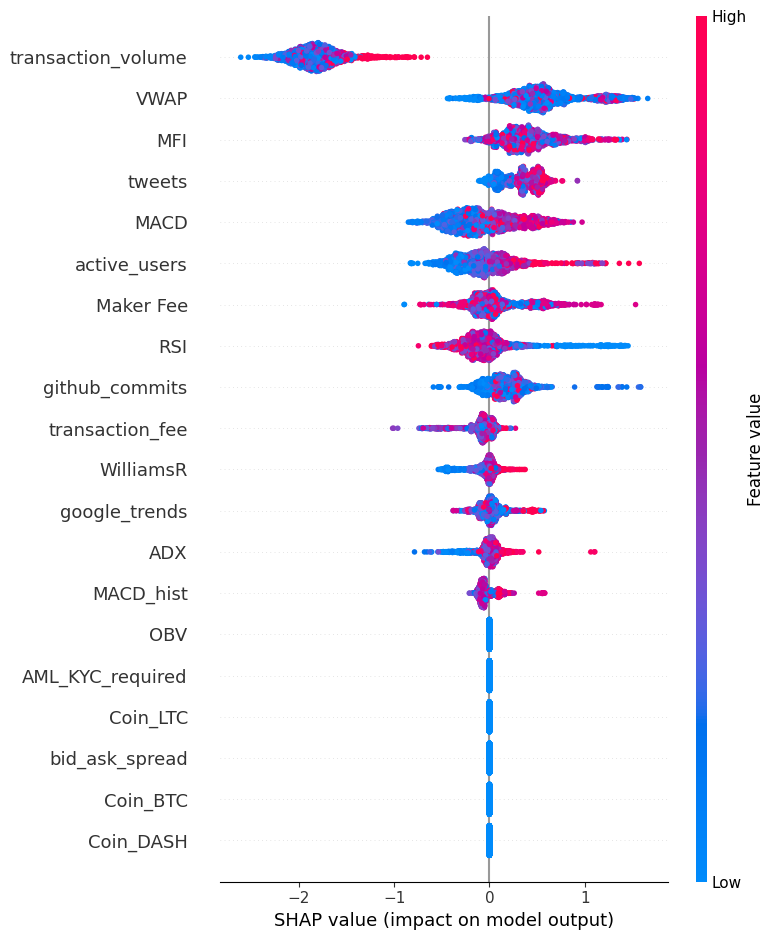

Running Global Feature Importance SHAP analysis for Coinbase...


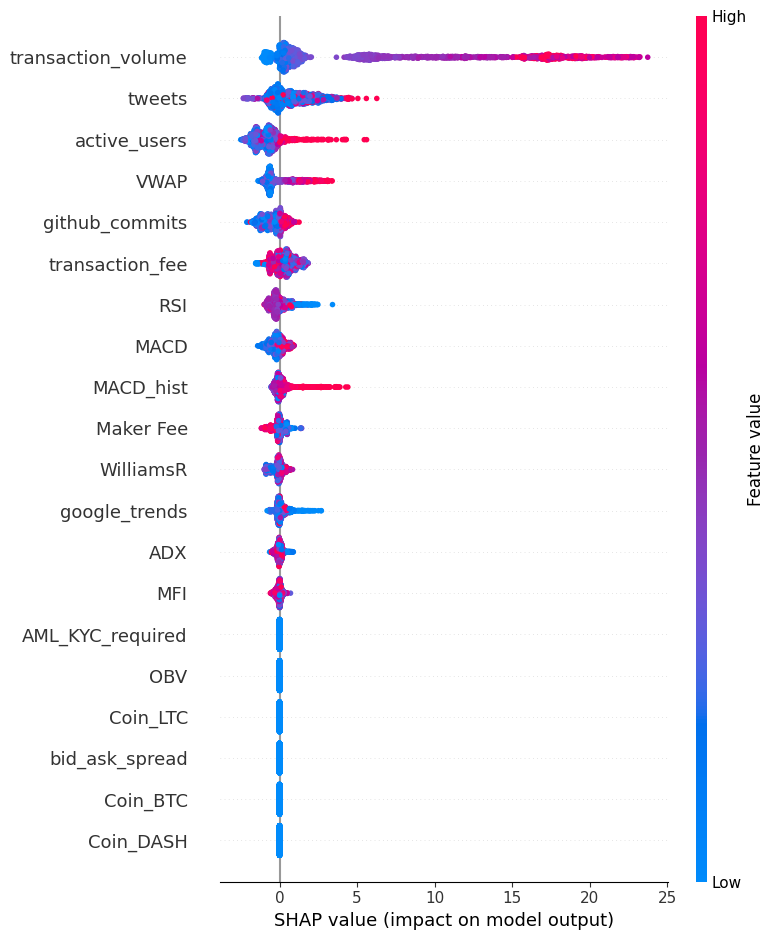



Running Global Feature Importance SHAP analysis for Binance...


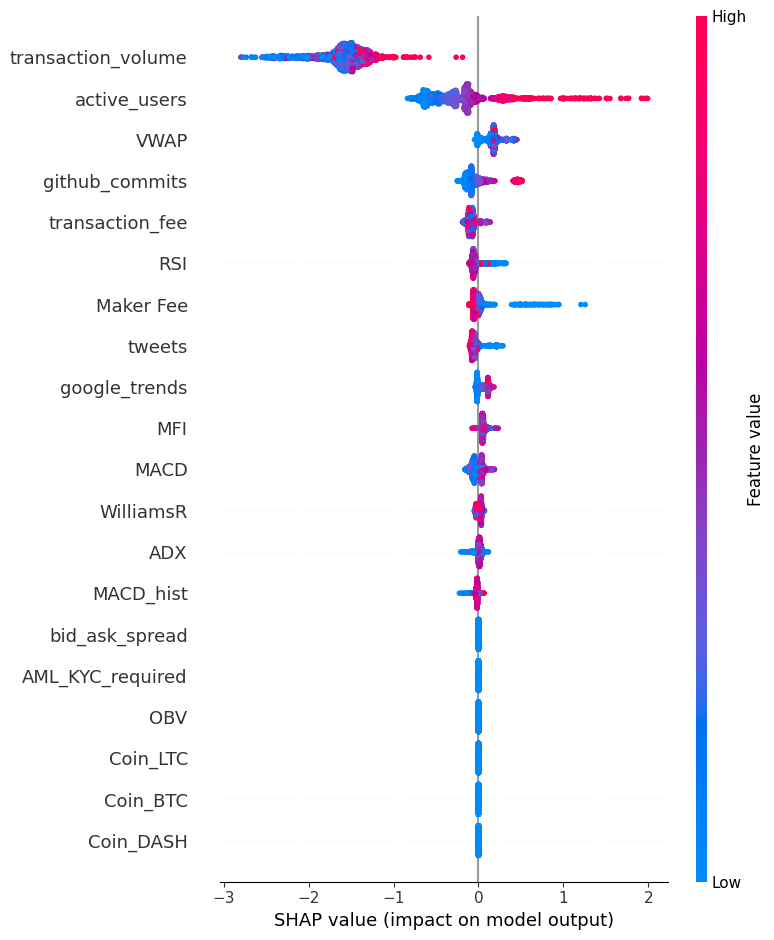

In [58]:
print("Running Global Feature Importance SHAP analysis for Kraken...")
print("\n")
shap.summary_plot(kraken_shap_values, kraken_X_test_scaled, feature_names=feature_names)
print("Running Global Feature Importance SHAP analysis for Coinbase...")
shap.summary_plot(coinbase_shap_values, coinbase_X_test_scaled, feature_names=feature_names)
print("\n")
print("Running Global Feature Importance SHAP analysis for Binance...")
shap.summary_plot(binance_shap_values, binance_X_test_scaled, feature_names=feature_names)


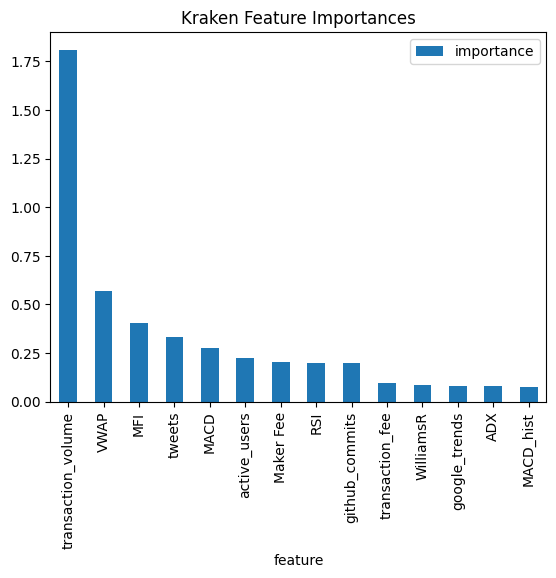

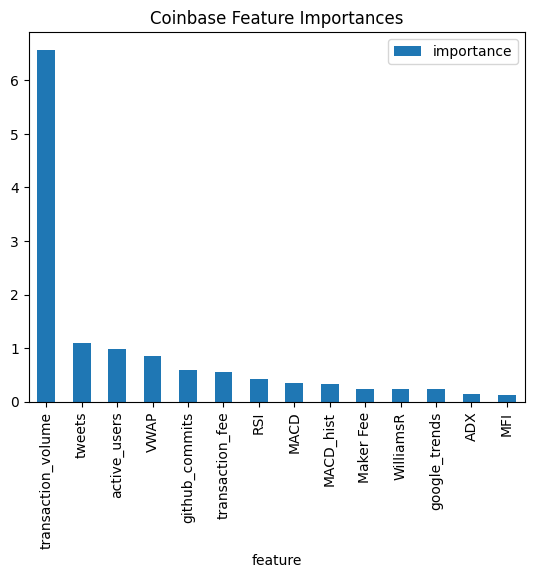

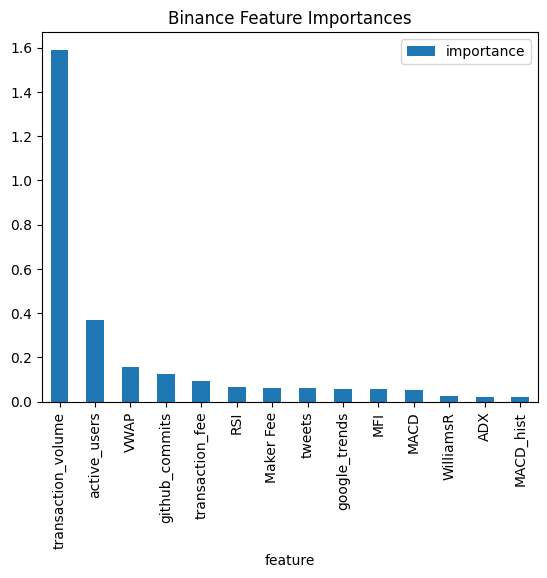

In [59]:
# Calculate SHAP values for each model
kraken_shap_values = kraken_explainer(kraken_X_test_scaled)
coinbase_shap_values = coinbase_explainer(coinbase_X_test_scaled)
binance_shap_values = binance_explainer(binance_X_test_scaled)

# Calculate mean absolute SHAP values for each feature
kraken_mean_shap_values = np.abs(kraken_shap_values.values).mean(axis=0)
coinbase_mean_shap_values = np.abs(coinbase_shap_values.values).mean(axis=0)
binance_mean_shap_values = np.abs(binance_shap_values.values).mean(axis=0)

# Create a DataFrame for each model to map features to their importances
kraken_importance_df = pd.DataFrame(list(zip(feature_names, kraken_mean_shap_values)), columns=['feature','importance'])
coinbase_importance_df = pd.DataFrame(list(zip(feature_names, coinbase_mean_shap_values)), columns=['feature','importance'])
binance_importance_df = pd.DataFrame(list(zip(feature_names, binance_mean_shap_values)), columns=['feature','importance'])

# Sort the DataFrame by importance
kraken_importance_df = kraken_importance_df.sort_values(by='importance', ascending=False)
coinbase_importance_df = coinbase_importance_df.sort_values(by='importance', ascending=False)
binance_importance_df = binance_importance_df.sort_values(by='importance', ascending=False)

# Plot bar charts
kraken_importance_df.head(14).plot(kind='bar', x='feature', y='importance', title='Kraken Feature Importances')
coinbase_importance_df.head(14).plot(kind='bar', x='feature', y='importance', title='Coinbase Feature Importances')
binance_importance_df.head(14).plot(kind='bar', x='feature', y='importance', title='Binance Feature Importances')
plt.show()


# **LOCAL FEATURE IMPORTANCE**

In [74]:
import time
# Define a list of feature names
feature_cols = ['transaction_volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'transaction_fee', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'OBV', 'AML_KYC_required', 'bid_ask_spread',
       'active_users', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC',
       'Coin_XRP']

def plot_local_importance_for_exchanges(explainer, X_test_scaled, feature_names, observation_index=100):
    # Choose an observation to explain
    observation = X_test_scaled[observation_index]
    # Reshape the observation to have two dimensions
    observation = observation.reshape(1, -1)

    # Calculate the SHAP values for the observation
    shap_values_local = explainer(observation)
    shap.initjs()

    # Plot the local feature importance
    return shap.force_plot(explainer.expected_value, shap_values_local.values, observation, feature_names=feature_names)

# Running for all exchanges
print("Local importance for Kraken")
plot_local_importance_for_exchanges(kraken_explainer, kraken_X_test_scaled, feature_cols)


Local importance for Kraken


In [72]:
print("Local importance for Coinbase")
plot_local_importance_for_exchanges(coinbase_explainer, coinbase_X_test_scaled, feature_cols)



Local importance for Coinbase


In [75]:
print("Local importance for Binance")
plot_local_importance_for_exchanges(binance_explainer, binance_X_test_scaled, feature_cols)


Local importance for Binance


(6873, 1, 21)
(2291, 1, 21)
(2291, 1, 21)


Epoch: 1/100, Training Loss: 0.0019, Validation Loss: 0.0019
Epoch: 2/100, Training Loss: 0.0010, Validation Loss: 0.0020
Epoch: 3/100, Training Loss: 0.0009, Validation Loss: 0.0027
Epoch: 4/100, Training Loss: 0.0008, Validation Loss: 0.0026
Epoch: 5/100, Training Loss: 0.0008, Validation Loss: 0.0027


Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch: 1/100, Training Loss: 0.0022, Validation Loss: 0.0021
Epoch: 2/100, Training Loss: 0.0011, Validation Loss: 0.0021
Epoch: 3/100, Training Loss: 0.0011, Validation Loss: 0.0026
Epoch: 4/100, Training Loss: 0.0011, Validation Loss: 0.0024
Epoch: 5/100, Training Loss: 0.0010, Validation Loss: 0.0025
Epoch: 1/100, Training Loss: 0.0011, Validation Loss: 0.0019
Epoch: 2/100, Training Loss: 0.0009, Validation Loss: 0.0022
Epoch: 3/100, Training Loss: 0.0009, Validation Loss: 0.0022
Epoch: 4/100, Training Loss: 0.0008, Validation Loss: 0.0015
Epoch: 5/100, Training Loss: 0.0008, Validation Loss: 0.0017
Epoch: 6/100, Training Loss: 0.0008, Validation Loss: 0.0016
Epoch: 7/100, Training Loss: 0.0007, Validation Loss: 0.0017
Epoch: 8/100, Training Loss: 0.0007, Validation Loss: 0.0016
Epoch: 1/100, Training Loss: 0.0013, Validation Loss: 0.0016
Epoch: 2/100, Training Loss: 0.0010, Validation Loss: 0.0024
Epoch: 3/100, Training Loss: 0.0010, Validation Loss: 0.0015
Epoch: 4/100, Training L

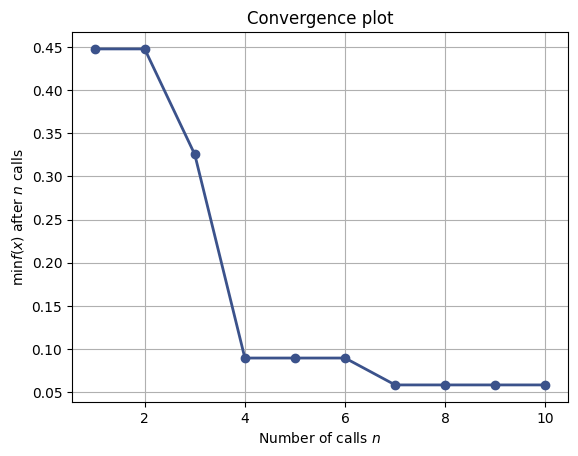

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skopt import BayesSearchCV
import shap
from functools import partial
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args



# Custom Dataset class to work with PyTorch DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Your data preprocessing code remains the same

# Create custom PyTorch model
class CNNBiLSTM(nn.Module):
    def __init__(self, input_size, conv_filters, lstm_units, dense_units, dropout_rate):
        super(CNNBiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(1, conv_filters, kernel_size=input_size, padding=0)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.bilstm = nn.LSTM(conv_filters, lstm_units, bidirectional=True, batch_first=True)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(2*lstm_units, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.transpose(1, 2)  # Transpose the dimensions to make the output compatible with LSTM
        x, _ = self.bilstm(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



# Your hyperparameter search code remains the same

def train_evaluate_model(params):
    conv_filters = params[0]
    lstm_units = params[1]
    dense_units = params[2]
    learning_rate = params[3]
    dropout_rate = params[4]
    batch_size = int(params[5])  # Convert batch_size to an integer

    model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = TimeSeriesDataset(X_val_scaled, y_val)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    # Train the model
    epochs = 100
    patience = 4
    min_val_loss = np.inf
    counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                outputs = torch.squeeze(outputs)  # Add this line to remove the extra dimension
                loss = criterion(outputs, batch_y)
                val_loss += loss.item()

        print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {running_loss/len(train_loader):.4f}, Validation Loss: {val_loss/len(val_loader):.4f}')

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            counter = 0
        else:
            counter += 1

        if counter >= patience:
            break

    return val_loss


# Define the search space for hyperparameters
search_space = [Integer(32, 128, name='conv_filters'),
                Integer(32, 128, name='lstm_units'),
                Integer(16, 64, name='dense_units'),
                Real(1e-4, 1e-2, prior='log-uniform', name='learning_rate'),
                Real(0.1, 0.5, name='dropout_rate'),
                Integer(8, 64, name='batch_size'),
                Categorical(['adam', 'adamax', 'rmsprop'], name='optimizer'),
                Categorical(['relu', 'linear'], name='activation')]

# Run Bayesian optimization
from skopt.plots import plot_convergence

# Run Bayesian optimization
result = gp_minimize(train_evaluate_model,
                     search_space,
                     n_calls=10,
                     random_state=42)

# Plot the convergence curve
plot_convergence(result)

# Print the best hyperparameters
best_params = result.x
print(f'Best hyperparameters: {best_params}')


In [ ]:
print("Best hyperparameters returned by Bayesian Optimization:",best_params)

Best hyperparameters returned by Bayesian Optimization: [86, 35, 56, 0.00079342935945906, 0.25806009440072586, 60, 'adamax', 'linear']


Epoch: 1/1000, Training Loss: 0.0045, Test Loss: 0.0058
Epoch: 2/1000, Training Loss: 0.0017, Test Loss: 0.0069
Epoch: 3/1000, Training Loss: 0.0014, Test Loss: 0.0074
Epoch: 4/1000, Training Loss: 0.0013, Test Loss: 0.0067
Epoch: 5/1000, Training Loss: 0.0013, Test Loss: 0.0070
Epoch: 6/1000, Training Loss: 0.0012, Test Loss: 0.0074
Epoch: 7/1000, Training Loss: 0.0011, Test Loss: 0.0058
Epoch: 8/1000, Training Loss: 0.0011, Test Loss: 0.0063
Epoch: 9/1000, Training Loss: 0.0010, Test Loss: 0.0057
Epoch: 10/1000, Training Loss: 0.0009, Test Loss: 0.0054
Epoch: 11/1000, Training Loss: 0.0009, Test Loss: 0.0056
Epoch: 12/1000, Training Loss: 0.0009, Test Loss: 0.0052
Epoch: 13/1000, Training Loss: 0.0009, Test Loss: 0.0049
Epoch: 14/1000, Training Loss: 0.0008, Test Loss: 0.0046
Epoch: 15/1000, Training Loss: 0.0008, Test Loss: 0.0049
Epoch: 16/1000, Training Loss: 0.0008, Test Loss: 0.0040
Epoch: 17/1000, Training Loss: 0.0008, Test Loss: 0.0036
Epoch: 18/1000, Training Loss: 0.0008, T

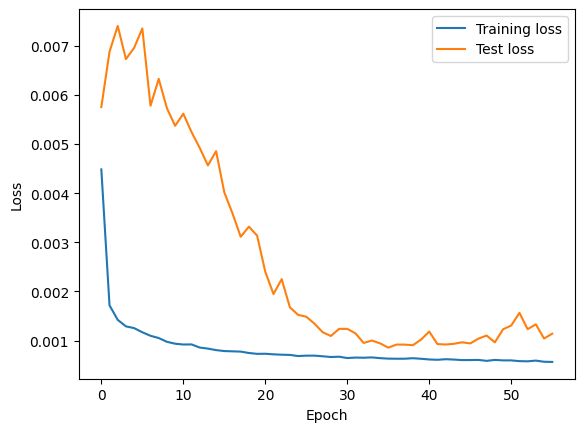

In [ ]:

# Train the final model on the full dataset
best_params = result.x
conv_filters = best_params[0]
lstm_units = best_params[1]
dense_units = best_params[2]
learning_rate = best_params[3]
dropout_rate = best_params[4]
#batch_size = best_params[5]
batch_size = int(best_params[5])  # Convert batch_size to an integer


final_model = CNNBiLSTM(X_train_scaled.shape[2], conv_filters, lstm_units, dense_units, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=learning_rate)

train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TimeSeriesDataset(X_test_scaled, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Train the final model on the full dataset
epochs = 1000
patience = 20
min_test_loss = np.inf
counter = 0

train_losses = []
test_losses = []
for epoch in range(epochs):
    final_model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        outputs = torch.squeeze(outputs)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    final_model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = final_model(batch_X)
            outputs = torch.squeeze(outputs)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()
    test_losses.append(test_loss / len(test_loader))

    # Print progress and loss values
    print(f'Epoch: {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    if test_loss < min_test_loss:
        min_test_loss = test_loss
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        break

# Plot the training and test loss
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object for the target variable
scaler_y = MinMaxScaler()

# Fit the scaler on the training data
scaler_y.fit(y_train.values.reshape(-1, 1))

def predict(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_X, _ in data_loader:
            outputs = model(batch_X)
            outputs = torch.squeeze(outputs)
            predictions.extend(outputs.numpy())
    return np.array(predictions)

# Make predictions on the training data
y_train_pred_scaled = predict(final_model, train_loader)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1))

# Calculate MSE, MAE, and MAPE on the training data
train_mse = mean_squared_error(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

# Print the results
print(f'Training MSE: {train_mse:.4f}')
print(f'Training MAE: {train_mae:.4f}')
print(f'Training MAPE: {train_mape:.2f}%')

# Make predictions on the test data
y_test_pred_scaled = predict(final_model, test_loader)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1))

# Calculate MSE, MAE, and MAPE on the test data
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the results
print(f'Test MSE: {test_mse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.2f}%')


Training MSE: 0.0029
Training MAE: 0.0395
Training MAPE: 0.55%
Test MSE: 0.0021
Test MAE: 0.0372
Test MAPE: 0.67%


In [ ]:
from torchvision import transforms

#  defining dataset class
class CustomMask(Dataset):
  def __init__(self, data, transforms=None):
    self.data = data
    self.transforms = transforms

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    image = self.data[idx]

    if self.transforms!=None:
      image = self.transforms(image)
    return image
    
#  creating explainer mask
mask = test_dataset[:200]

#  turning mask to pytorch dataset
mask = CustomMask(mask, transforms=transforms.ToTensor())

In [ ]:
feature_names_list = list(X.columns)
feature_names_list

['open',
 'high',
 'low',
 'close',
 'volume',
 'github_commits',
 'google_trends',
 'tweets',
 'VWAP',
 'OBV',
 'MFI',
 'ADX',
 'MACD',
 'MACD_signal',
 'MACD_hist',
 'RSI',
 'WilliamsR',
 'Maker Fee',
 'Transaction Fee',
 'AML_KYC_required',
 'Coin_BTC',
 'Coin_DASH',
 'Coin_ETH',
 'Coin_LTC',
 'Coin_XRP']

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
feature_names_list = list(X.columns)
print("Feature names list: ",feature_names_list)
def plot_shap(data, mask, model,feature_names_list):
    """
    This function performs model explainability
    by producing shap plots for a data instance
    """
    #  converting data to tensor
    data_tensor = torch.from_numpy(data).float().to(device)

    #-----------------
    #  CLASSIFICATION
    #-----------------
    #  utilizing the model for prediction
    with torch.no_grad():
        prediction = model(data_tensor).item()

    #  displaying model prediction
    print(f'prediction: {prediction}')

    #----------------
    #  EXPLANABILITY
    #----------------
    #  creating dataloader for mask
    mask_loader = DataLoader(mask, batch_size=200)

    #  creating explainer for model behaviour
    for images in mask_loader:
        images = images.to(device)
        explainer = shap.DeepExplainer(model, images)
        break

    #  deriving shap values for image of interest based on model behaviour
    shap_values = explainer.shap_values(data_tensor)

    #  preparing for visualization by flattening and transposing shap values and data
    shap_values = np.abs(shap_values).mean(0).T
    data_flattened = data.reshape(-1, data.shape[-1]).T

    #  producing shap plots
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(feature_names_list, shap_values[prediction])
    ax.set_xlabel('Feature Importance')
    ax.set_title('SHAP Feature Importance')
    plt.show()


Feature names list:  ['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR', 'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'Coin_BTC', 'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP']


In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the GPU


In [ ]:

# Load and preprocess your data (assuming kraken_data_encoded is already preprocessed)
#X = kraken_data_encoded.drop('bid_ask_spread', axis=1)
#y = kraken_data_encoded['bid_ask_spread']

# Split the data into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Then split the training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, shuffle=False)

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and validation data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Reshape the input data to fit the CNN-BiLSTM model (samples, time steps, features)
#X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
#X_val_scaled = np.reshape(X_val_scaled, (X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
#X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(6873, 21)
(2291, 21)
(2291, 21)


# **LightGBM based prediction for SHAP analysis**

In [ ]:
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Integer


# Create a LightGBM regressor
lgbm = lgb.LGBMRegressor()

# Define the hyperparameter search space
search_space = {
    'learning_rate': Real(0.01, 1.0),
    'n_estimators': Integer(10, 1000),
    'num_leaves': Integer(2, 100),
    'min_child_samples': Integer(1, 100),
    'subsample': Real(0.1, 1.0),
    'colsample_bytree': Real(0.1, 1.0)
}

# Create a BayesSearchCV object
opt = BayesSearchCV(lgbm, search_space, n_iter=32)

# Fit the optimizer on the training data
opt.fit(X_train_scaled, y_train)

# Print the best hyperparameters
print(opt.best_params_)

# Make predictions on the test data using the best model
y_pred = opt.predict(X_test_scaled)


OrderedDict([('colsample_bytree', 0.5100446320228752), ('learning_rate', 0.01), ('min_child_samples', 100), ('n_estimators', 441), ('num_leaves', 20), ('subsample', 1.0)])


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.metrics import mean_squared_error, mean_absolute_error

def mean_absolute_percentage_error1(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Make predictions on the training and test data
y_train_pred = opt.predict(X_train_scaled)
y_test_pred = opt.predict(X_test_scaled)

# Calculate the training metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)

# Calculate the test metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Print the training and test metrics
print(f'Training RMSE: {train_rmse:.4f}')
print(f'Training MAE: {train_mae:.4f}')
print(f'Training MAPE: {train_mape:.4f}%')
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')
print(f'Test MAPE: {test_mape:.4f}%')



Training RMSE: 0.0186
Training MAE: 0.0135
Training MAPE: 0.2633%
Test RMSE: 0.0298
Test MAE: 0.0240
Test MAPE: 0.6109%


The `shap.summary_plot` function creates a global feature importance plot. It shows the average impact of each feature on the model's output. The code you provided will create a summary plot using the SHAP values calculated for the scaled training data (`shap_values`) and the names of the features (`X_train.columns`).

In the summary plot, each dot represents the SHAP value for a single observation. The x-axis shows the SHAP value, which represents the impact of the feature on the model's output. A positive SHAP value means that the feature increases the model's output, while a negative SHAP value means that the feature decreases the model's output.

The features are sorted by their importance, with the most important features at the top of the plot. The importance of a feature is determined by the magnitude of its SHAP values. A feature with large positive or negative SHAP values is considered more important than a feature with small SHAP values.

The color of each dot represents the value of the feature for that observation. Red dots indicate high feature values, while blue dots indicate low feature values. This allows you to see how the impact of a feature on the model's output varies depending on its value.

Overall, the summary plot provides a global overview of how each feature impacts the model's output on average.

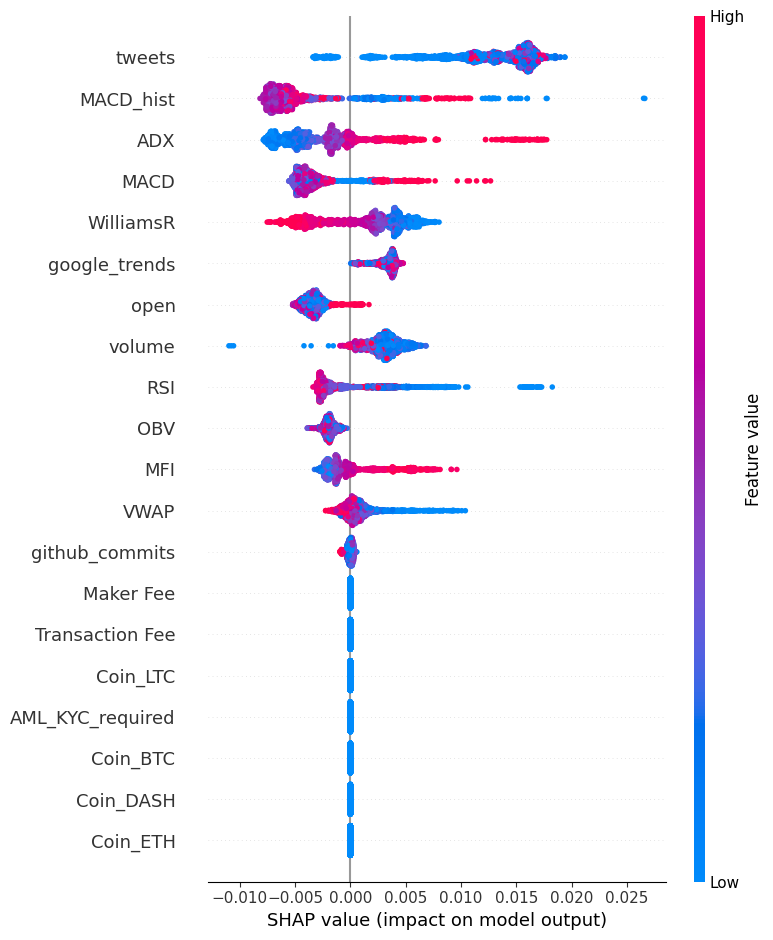

In [ ]:
import shap

# Create an explainer object
explainer = shap.Explainer(opt.best_estimator_)

# Calculate the SHAP values for the test data
shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test.columns)



# **GLOBAL FEATURE IMPORTANCE**
The shap.plots.bar function displays the global feature importance. Global feature importance refers to the average impact of each feature on the model’s predictions across all observations in the dataset.

In contrast, local feature importance refers to the impact of each feature on the model’s prediction for a single observation

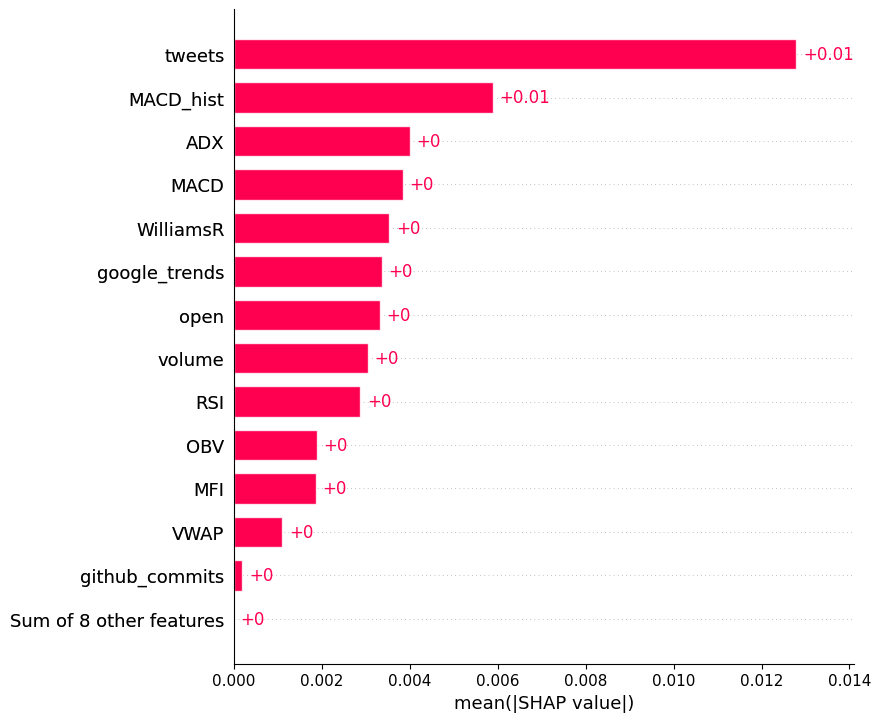

In [ ]:
# Calculate the SHAP values for all observations in your dataset
shap_values = explainer(X_test_scaled)

# Set the feature names on the shap_values object
shap_values.feature_names = X_test.columns

# Plot the global feature importance
shap.plots.bar(shap_values,max_display=14)


In [ ]:
print(X_test.columns)

Index(['open', 'volume', 'github_commits', 'google_trends', 'tweets', 'VWAP',
       'OBV', 'MFI', 'ADX', 'MACD', 'MACD_hist', 'RSI', 'WilliamsR',
       'Maker Fee', 'Transaction Fee', 'AML_KYC_required', 'Coin_BTC',
       'Coin_DASH', 'Coin_ETH', 'Coin_LTC', 'Coin_XRP'],
      dtype='object')


In [ ]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with the feature names and mean absolute SHAP values
feature_importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': mean_abs_shap_values
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# Display the top 14 most important features as a table
feature_importance_df.head(22)


,feature,importance
4,tweets,0.015939
10,MACD_hist,0.005512
12,WilliamsR,0.005364
1,volume,0.004169
9,MACD,0.004169
3,google_trends,0.003751
7,MFI,0.002572
6,OBV,0.002408
0,open,0.001859
8,ADX,0.001526


In [ ]:
# Calculate the sum of all importance scores
total_importance = feature_importance_df['importance'].sum()

# Calculate the percentage importance for each feature
feature_importance_df['importance_percentage'] = (feature_importance_df['importance'] / total_importance) * 100

# Round the percentage importance values to 2 decimal places
feature_importance_df['importance_percentage'] = feature_importance_df['importance_percentage'].round(2)

# Display the top 14 most important features as a table
feature_importance_df[['feature', 'importance_percentage']].head(14)
# Save the feature importance scores as a CSV file
feature_importance_df.to_csv('feature_importance_kraken.csv', index=False)


# **LOCAL FEATURE IMPORTANCE**

In [ ]:
import matplotlib.pyplot as plt
print("Feature 100 Local importance")
print(X_test_scaled.shape)

# Choose an observation to explain
observation = X_test_scaled[100]

# Reshape the observation to have two dimensions
observation = observation.reshape(1, -1)

# Calculate the SHAP values for the observation
shap_values = explainer(observation)
shap.initjs()

# Plot the local feature importance
#shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns,matplotlib=True,show=False)
shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns)


Feature 100 Local importance
(2291, 21)


In [ ]:
import matplotlib.pyplot as plt
print(" Local Feature importance of Feature 0")
print(X_test_scaled.shape)

# Choose an observation to explain
observation = X_test_scaled[0]

# Reshape the observation to have two dimensions
observation = observation.reshape(1, -1)

# Calculate the SHAP values for the observation
shap_values = explainer(observation)
shap.initjs()

# Plot the local feature importance
#shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns,matplotlib=True,show=False)
shap.force_plot(explainer.expected_value, shap_values.values, observation, feature_names=X_test.columns)


 Local Feature importance of Feature 0
(2291, 21)


<Figure size 640x480 with 0 Axes>

In [ ]:
X_test.columns


Index(['open', 'high', 'low', 'close', 'volume', 'github_commits',
       'google_trends', 'tweets', 'VWAP', 'OBV', 'MFI', 'ADX', 'MACD',
       'MACD_signal', 'MACD_hist', 'RSI', 'WilliamsR', 'Maker Fee',
       'Transaction Fee', 'AML_KYC_required', 'Coin_BTC', 'Coin_DASH',
       'Coin_ETH', 'Coin_LTC', 'Coin_XRP'],
      dtype='object')

In [ ]:
len(X_test.columns)

25

DimensionError: ignored